# Template for coursework - Part 2: Clustering

In [20]:
# import of libraries
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from scipy import stats
import numpy as np



## Team identification

* seminar day and time
ST 9:15
* team number
Team D
* names of team members
Michal Červinka, Filip Dvořák, Tomáš Jareš, Dominik Šimon

# Introduction

1.	Describe the business value of addressing this problem with machine learning.

    Použití strojového učení na dataset diabetu může výrazně přispět k zlepšení zdravotní péče. Umožňuje časnou detekci a diagnostiku diabetu, vytváření personalizovaných léčebných plánů, předpovídání pravděpodobnosti komplikací, stratifikaci pacientů na základě rizika a efektivní řízení a sledování nemoci. Tímto způsobem může strojové učení zlepšit klinické 
    rozhodování, výsledky pacientů a přispět k efektivnějšímu poskytování zdravotní péče.

2.	Provide the link to the source of the data.
    https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

## Customization

//TODO

1.	What is the *target attribute*
2.	What is the *instance of interest*   The instance can be identified, for example, by an id.
3.	Choose an *attribute of interest* 
5.	Show *Cost matrix* consisting of a cost of a false positive, false negative, true positive and true negative. Note that cost of true positive and true negative is recommended to be zero.

# Data preprocessing

## Preprocessing for unsupervised machine learning 

* As clustering is  performed only on the chosen subset of data, remove data not in the subgroup
* Perform min-max feature rescaling
* remove target attribute from clustering
* do *not* create train-test splits

In [21]:

data = pd.read_csv("diabetes_prediction_dataset.csv")
data

#Vybrání dat bez cílové proměnné
X = data.drop('diabetes', axis=1)

#Vytvoření subsetu
X=X.drop('gender', axis=1)
X=X.drop('smoking_history',axis=1)
print(X.head())

np.random.seed(10)
X = X.sample(frac=0.01, random_state=11)


# Calculate z-scores for each column in X
z_scores = stats.zscore(X)

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 3

# Remove rows with z-scores greater than the threshold
X = X[(np.abs(z_scores) < threshold).all(axis=1)]


#Standard scaling
scaler = StandardScaler()
X[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(X[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])
print(X.describe()) #tabulka pro kontrolu min a max value 

print("Number of rows in X:", X.shape[0])



    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level
0  80.0             0              1  25.19          6.6                  140
1  54.0             0              0  27.32          6.6                   80
2  28.0             0              0  27.32          5.7                  158
3  36.0             0              0  23.45          5.0                  155
4  76.0             1              1  20.14          4.8                  155
                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  8.660000e+02         866.0          866.0  8.660000e+02  8.660000e+02   
mean   3.261440e-16           0.0            0.0  1.948659e-16  6.892100e-16   
std    1.000578e+00           0.0            0.0  1.000578e+00  1.000578e+00   
min   -1.786615e+00           0.0            0.0 -2.232469e+00 -1.928265e+00   
25%   -8.492887e-01           0.0            0.0 -6.537951e-01 -6.301482e-01   
50%   -2.442267e-02           0.0            0.0  1.

## Modeling and visualization

* do not include target attribute among variables for clustering

### Clustering 1 (k-means)

* Use the elbow curve graph to find the best value of inertia (wcss)
* It is recommended to use two measures (such as the Silhouette score and the Inertia) and compare the resulting number of clusters based on their best values.
* Create a scatter plot for each cluster and use color

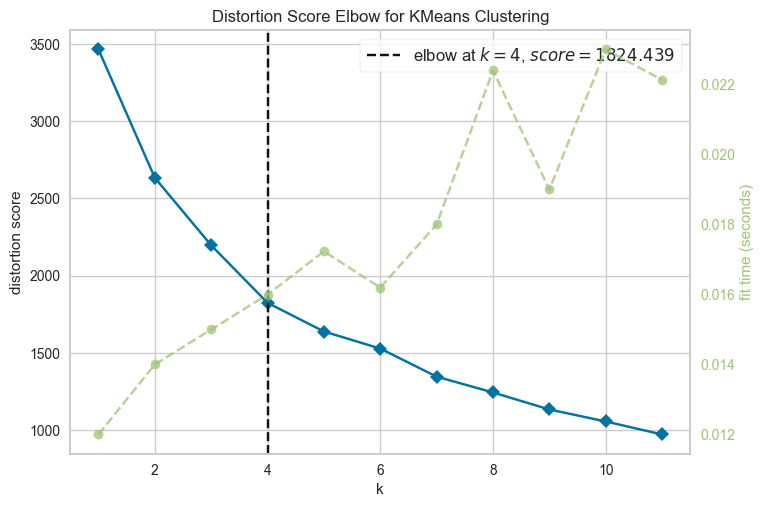

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
#Vizualizace Elbow grafu
kmeans_tune = KMeans(random_state=42,n_init = 2,max_iter=10)
visualizer = KElbowVisualizer(kmeans_tune, k=(1,12))
visualizer.fit(X)
visualizer.show()

In [23]:
kmeansElbow = KMeans(n_clusters=4, random_state=42)
kmeansElbow.fit(X)
# spočítání Silhouette Score:
silhouette_avg = silhouette_score(X, kmeansElbow.labels_)
print("silhouette_score pro K=4:", silhouette_avg)

#výpis inertii
print("inertia pro K=4: ", kmeansElbow.inertia_)

kmeansTwo = KMeans(n_clusters=2, random_state=42)
kmeansTwo.fit(X)
# spočítání Silhouette Score:
silhouette_avg = silhouette_score(X, kmeansTwo.labels_)
print("silhouette_score pro k=2:", silhouette_avg)
#výpis inertii
print("inertia pro k=2: ", kmeansTwo.inertia_)


silhouette_score pro K=4: 0.2362571872791669
inertia pro K=4:  1824.3933076549972
silhouette_score pro k=2: 0.2202006337086197
inertia pro k=2:  2633.459405930618


C:\Users\cervi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


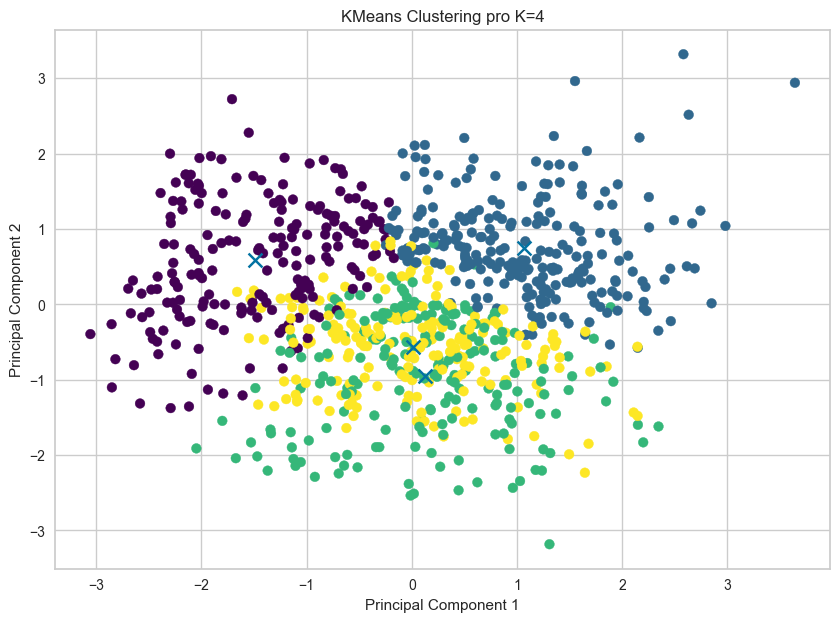

C:\Users\cervi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


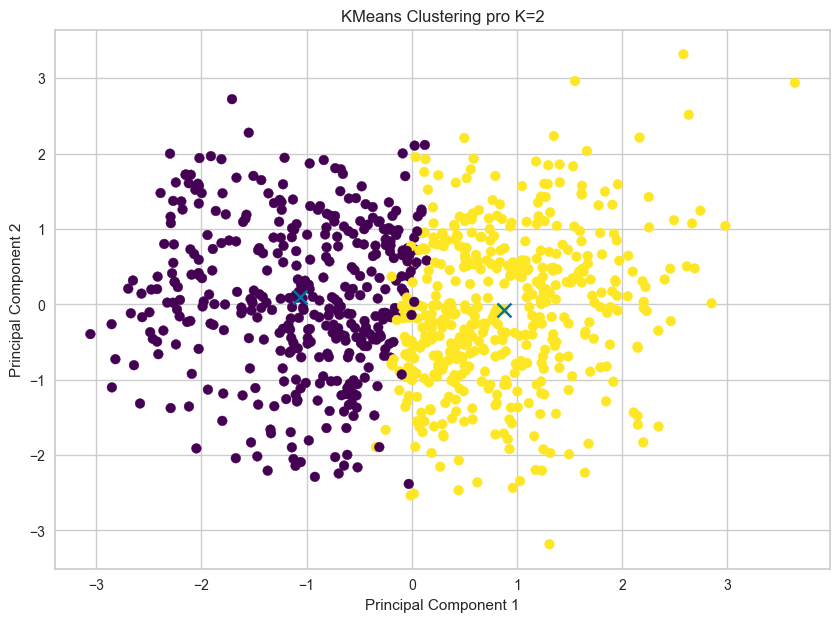

Text(0, 0.5, 'HbA1c_level')

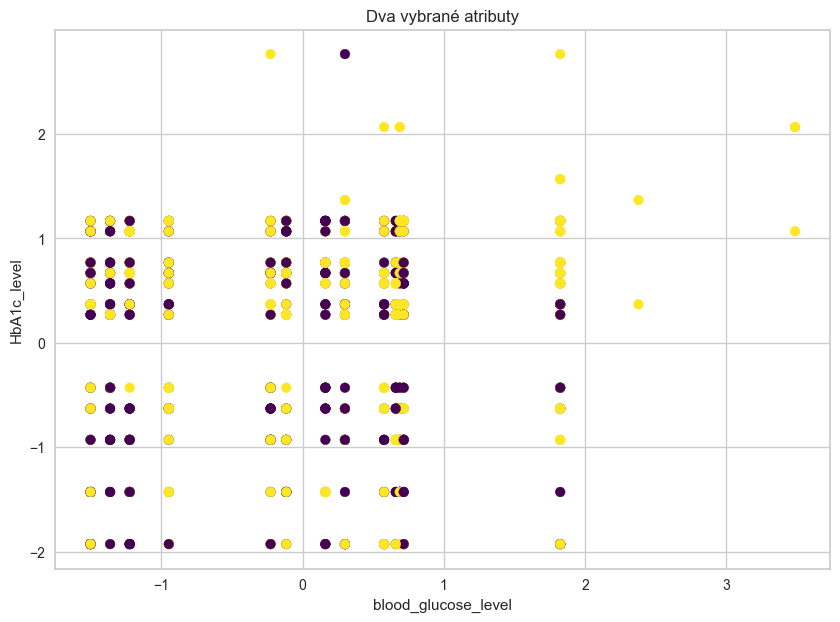

In [24]:
#PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

#Určení centoridů
centroids = pca.transform(kmeansElbow.cluster_centers_)

#Vytvoření DataFramu s principal componenty
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['Cluster'] = kmeansElbow.labels_

# Plotování clusteru pro K=4
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')

# Plotování centroidů pro K=4
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering pro K=4')
plt.show()

#Plotování clusterů pro K=2
centroids = pca.transform(kmeansTwo.cluster_centers_)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['Cluster'] = kmeansTwo.labels_
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering pro K=2')
plt.show()


#plot pro dva vybrané atributy

kmeansTwoAttributes = KMeans(n_clusters=2, random_state=42)
kmeansTwoAttributes.fit(X)
X['Cluster'] = kmeansTwoAttributes.labels_

plt.figure(figsize=(10, 7))
plt.scatter(X['blood_glucose_level'], X['HbA1c_level'], c=X['Cluster'], cmap='viridis')

plt.title('Dva vybrané atributy')
plt.xlabel('blood_glucose_level')
plt.ylabel('HbA1c_level')

### Clustering  2 (hierarchical)

* Try to use the dendrogram to identify outliers. If an instance joins a cluster higher on the dendrogram, it generally means it is less similar to the other instances. 

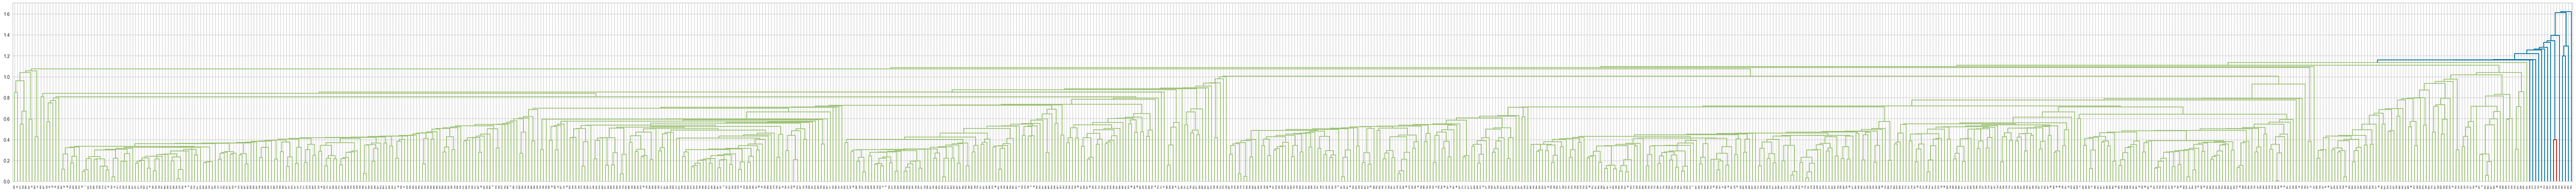

In [25]:
linked = linkage(X, 'single')

plt.figure(figsize=(100, 7 ))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

# Evaluation

## Global

### Clustering 1 (k-means)

* Compute the rand index using the value of the target attribute

In [26]:
y = data.loc[X.index, 'diabetes']


ari = adjusted_rand_score(y, kmeansElbow.labels_)
ariTwo = adjusted_rand_score(y,kmeansTwo.labels_)

print("ARI pro k=4: ", ari)
print("ARI pro k=2: ", ariTwo)


ARI pro k=4:  -0.0033791043486413245
ARI pro k=2:  -0.006539700904146268


### Clustering 2 (hierarchical)


* Compute the rand index using the value of the target attribute

In [27]:

clusters = fcluster(linked, 4, criterion='maxclust')


y = data.loc[X.index, 'diabetes']

ari = adjusted_rand_score(y, clusters)

print("ARI: ", ari)

ARI:  0.29755651699350943


## Local

*	Use the model to classify the chosen instance into a cluster

In [29]:
# Vybrání instance, která má podlé cílové proměnné cukrovku
instance_of_interest = X.iloc[24]

#reshapování instance_of_interest
instance_of_interest = instance_of_interest.values.reshape(1, -1)
instance_of_interest = pd.DataFrame(instance_of_interest, columns=X.columns)
print(instance_of_interest)

cluster_label = kmeansElbow.predict(instance_of_interest)
print("Cluster label: ", cluster_label)

labels = kmeansElbow.labels_


# Plotování clusterů
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')

# Plotování centroidů
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c="red",s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.scatter(instance_of_interest.iloc[0, 0], instance_of_interest.iloc[0, 1], c='red', edgecolor='black', linewidth=2, s=100)
plt.show()


        age  hypertension  heart_disease       bmi  HbA1c_level  \
0  1.416188           0.0            0.0 -0.442435     1.566665   

   blood_glucose_level  Cluster  
0             1.824309      1.0  


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cluster


# Explanation

## Global explanation

### Clustering 1 - k-means

*	Interpret the final clusters based on their centroids and the number of instances in each cluster.

In [ ]:

centroids = kmeansElbow.cluster_centers_


unique, counts = np.unique(kmeansElbow.labels_, return_counts=True)
cluster_counts = dict(zip(unique, counts))

print("Cluster Centroids:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}:")
    for j, column in enumerate(X.columns):
        print(f"{column}: {centroid[j]}")


print("\nNumber of Instances in Each Cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} instances")

Cluster Centroids:
Cluster 0:
age: -1.0468599877019422
hypertension: 0.0
heart_disease: 0.0
bmi: -0.9276979460221928
HbA1c_level: 0.11745834782535151
blood_glucose_level: 0.5024515412462228
Cluster 1:
age: 0.7409460058921994
hypertension: 0.0
heart_disease: 0.0
bmi: 0.4699775049485601
HbA1c_level: 0.774884232347407
blood_glucose_level: 0.8486536497636579
Cluster 2:
age: 0.5667036764038503
hypertension: 0.0
heart_disease: 0.0
bmi: 0.4614763134157013
HbA1c_level: 0.4635033385709778
blood_glucose_level: -0.9857385818365394
Cluster 3:
age: -0.8245675000555058
hypertension: 0.0
heart_disease: 0.0
bmi: -0.6035895121405558
HbA1c_level: -0.20453612834940585
blood_glucose_level: -1.244005443142818
Cluster 4:
age: 0.31355061954727564
hypertension: 0.0
heart_disease: 0.0
bmi: 0.4291158371001825
HbA1c_level: -1.223405217437032
blood_glucose_level: 0.28540683839962616

Number of Instances in Each Cluster:
Cluster 0: 191 instances
Cluster 1: 198 instances
Cluster 2: 168 instances
Cluster 3: 122 inst

### Clustering 2 - hierarchical

* Plot the dendrogram for clustering

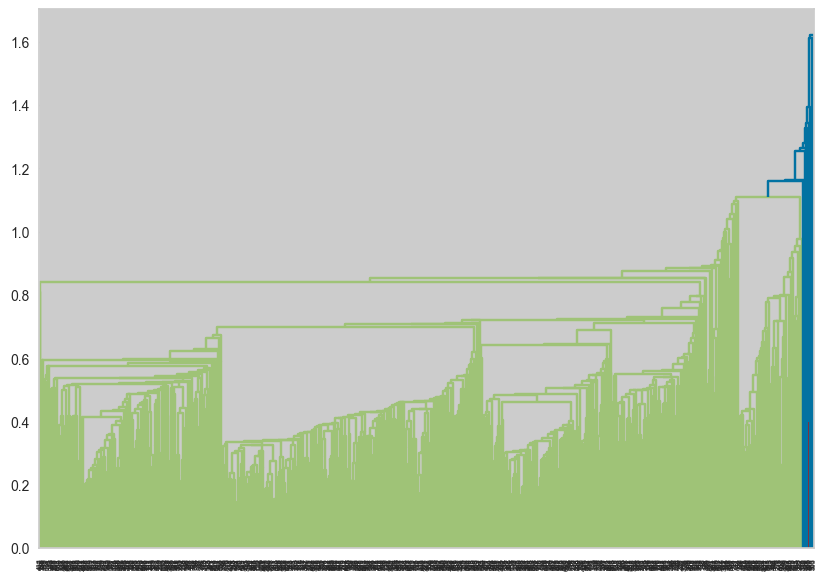

In [ ]:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

## Local explanation

* Use both models to show what cluster is assigned to the *instance of interest*
* Comment on the assigned cluster.

In [ ]:
# K-means model
kmeans_cluster = kmeansElbow.predict(instance_of_interest)
print("K-means Cluster: ", kmeans_cluster)

# Hierarchical model
hierarchical_cluster = fcluster(linked, 5, criterion='maxclust')
hierarchical_cluster = hierarchical_cluster[0]  # Assuming instance_of_interest is the first row
print("Hierarchical Cluster: ", hierarchical_cluster)




ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cluster


# Conclusion
Summarize the results, answering questions such as:

1.	Which clustering provided the most useful result? 
    Kmeans (lepší ari )
2.	What setting provided the best result?
    K= 4 - zjištěno z elbow grafu

# Optional parts

## Local explanation

*	Does the value of the target class in the data match with the mode (average) of the assigned cluster? As the target attribute was not included in the clustering, to compute this, you need to  match the instance of interest as well as the instances in the assigned cluster with the original input data and use this to obtain the target value (and compute the mean/mode for the assigned cluster)